# Analysis of click directivity
Based on the only recording of common dolphins passing during travel on both sides of the antenna.

## Parameters

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from utils.geometry import angle_modulo
from utils.plots import HandleResults

file = "Clicks_kit/detection_estimation/21072022_records/Seq_2022-07-21_11h17/concat_delays_with_angles_and_clusters.csv"

## Show DoAs
We only show azimuths as no dolphins went above the antenna (i.e. no animal jumped over it for some reason...).

In [2]:
res_handler = HandleResults(file, station_path="Clicks_kit/coords-tetra-2022.csv", media_folder="Audio_data/20220721")

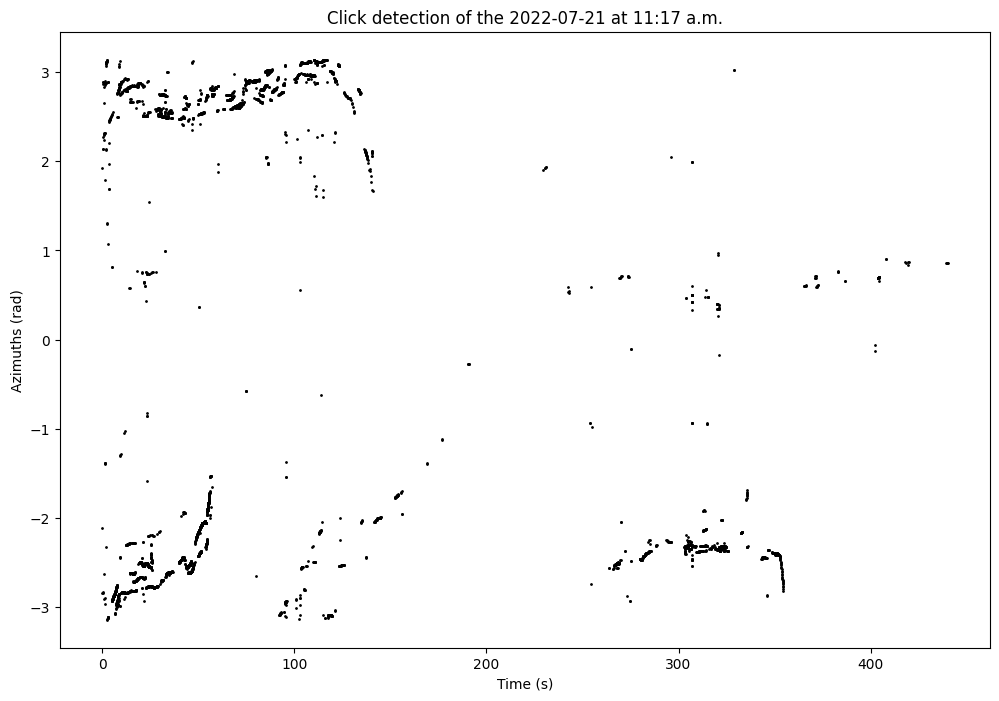

In [3]:
res_handler.plot_column(
    "azimuth", date_from=0, date_to=450, 
    title="Click detection of the 2022-07-21 at 11:17 a.m.", 
    xlabel="Time (s)", ylabel="Azimuths (rad)", 
    save=False)

/tmp/ipykernel_131276/569582316.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Figure saved in Clicks_kit/detection_estimation/21072022_records/Seq_2022-07-21_11h17/pictures/concat_delays_with_angles_and_clusters_polar_plots.pdf 


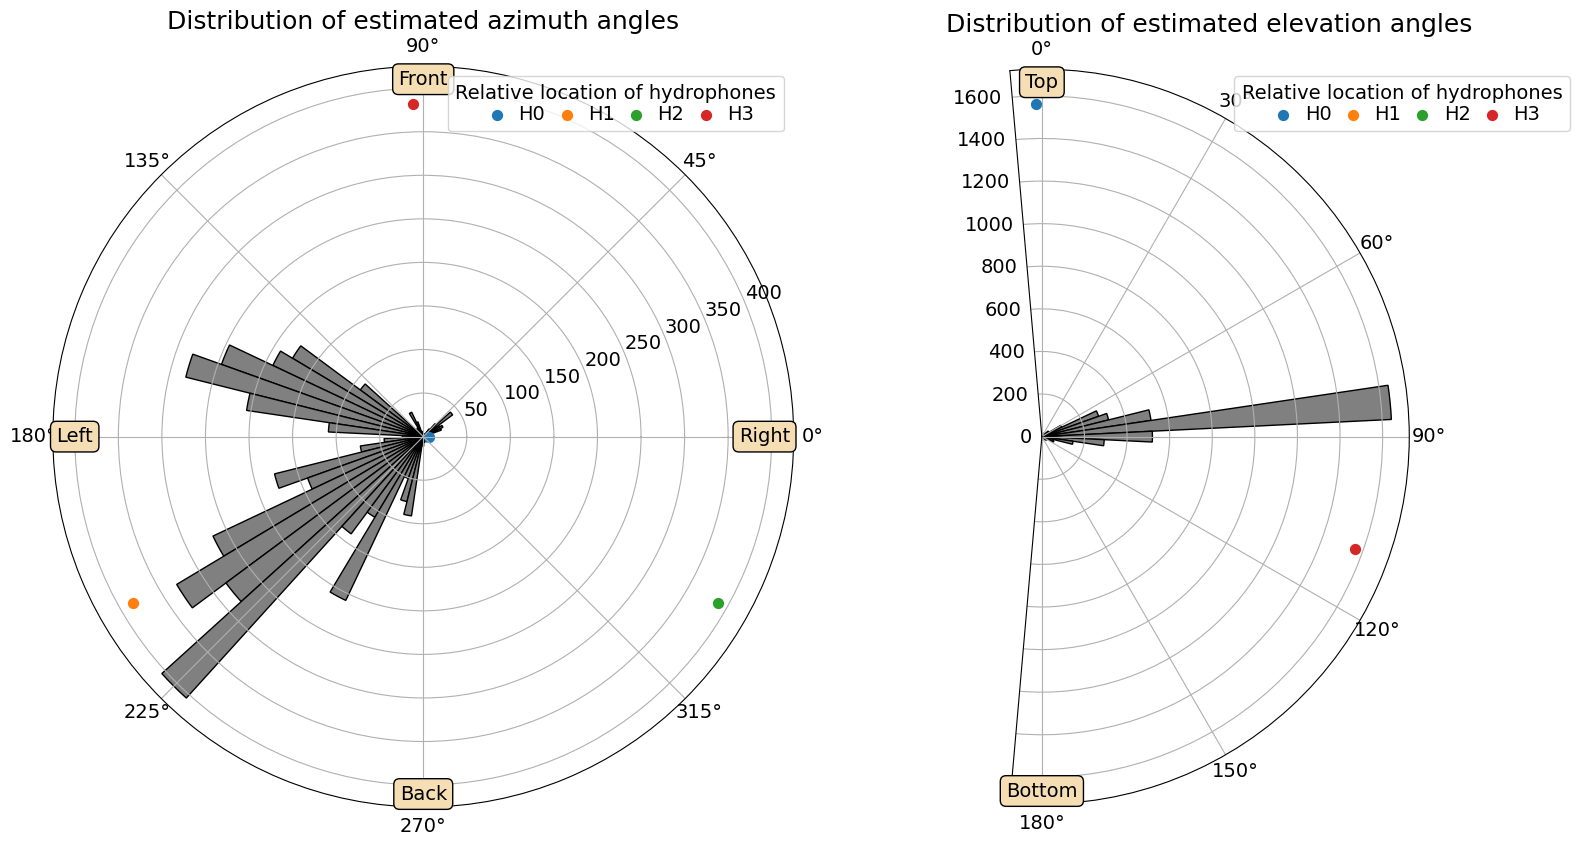

In [4]:
fig, axs = res_handler.polar_plots(date_from=0, date_to=450, N_angles=64, save=False)
fig.show()
res_handler.polar_plots(date_from=0, date_to=450, N_angles=64, save=True)

## Histogram of azimuths
### Show

/tmp/ipykernel_131276/216265197.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


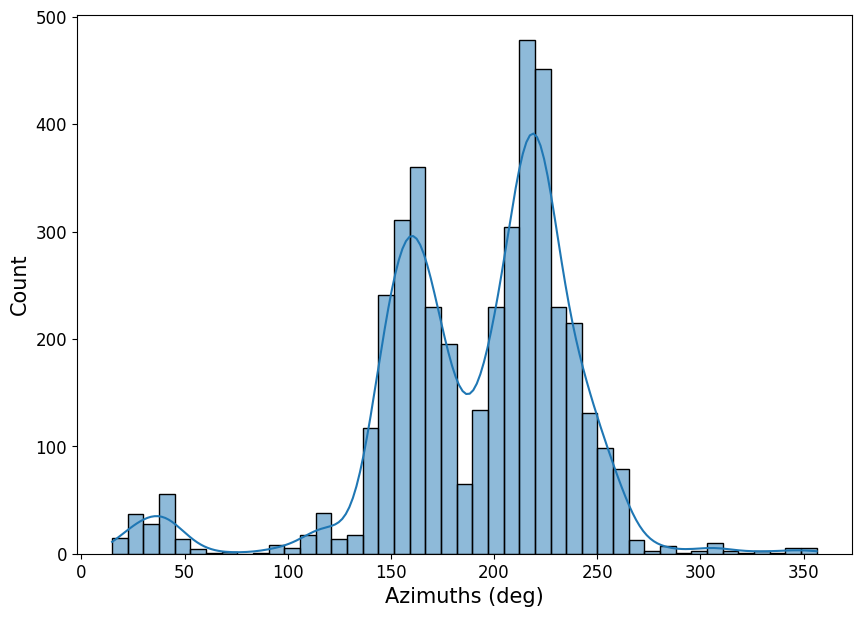

In [5]:
azimuths = angle_modulo(np.degrees(res_handler.data[res_handler.data.total_seconds < 450].azimuth)+180)+180

fig, ax = plt.subplots(figsize=(10,7))
sns.histplot(azimuths, kde=True, ax=ax)
ax.tick_params(axis='both', which='major', labelsize=12)
plt.ylabel("Count", fontsize=15)
plt.xlabel("Azimuths (deg)", fontsize=15)
fig.savefig("Clicks_kit/detection_estimation/21072022_records/Seq_2022-07-21_11h17/pictures/histogram_azimuths.pdf")
fig.show()

Obvious bimodal distribution, let's separate based on clustering of data

/tmp/ipykernel_131276/1339410854.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


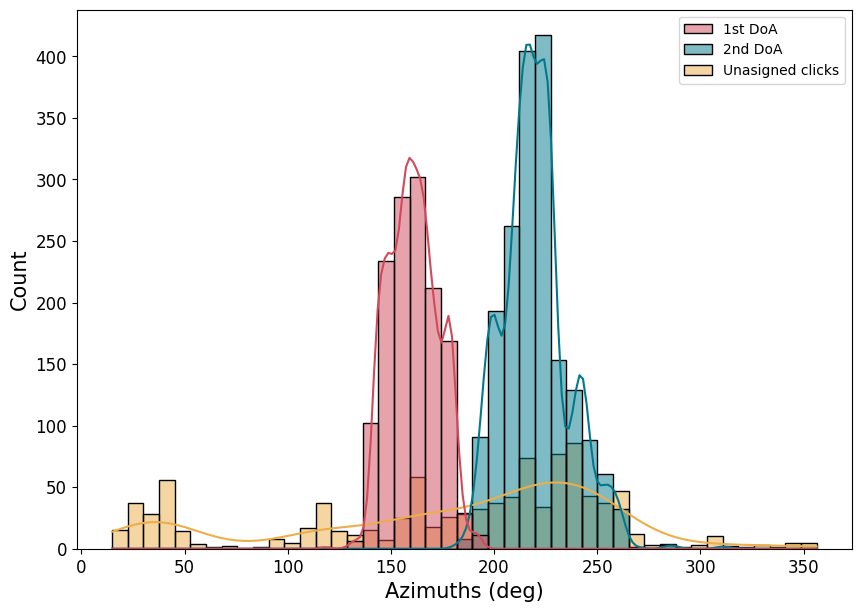

In [6]:
group_clusters = res_handler.data[res_handler.data.total_seconds < 450].clusters.copy().to_numpy()
hue_clusters = np.zeros(len(group_clusters), dtype='<U16')
for i, element in enumerate(group_clusters):
    if element in [3, 9, 12, 13, 14]:
        hue_clusters[i] = "1st DoA"
    elif element in [0, 6, 7, 11, 15, 16, 17, 18, 19, 20, 21, 22, 25]:
        hue_clusters[i] = "2nd DoA"
    else:
        hue_clusters[i] = "Unasigned clicks"


fig, ax = plt.subplots(figsize=(10,7))
sns.histplot(
    x=azimuths, palette=["#d1495b", "#00798c","#edae49"],
    hue=hue_clusters, hue_order=["1st DoA", "2nd DoA", "Unasigned clicks"],
    kde=True, ax=ax)
ax.tick_params(axis='both', which='major', labelsize=12)
plt.ylabel("Count", fontsize=15)
plt.xlabel("Azimuths (deg)", fontsize=15)
fig.savefig("Clicks_kit/detection_estimation/21072022_records/Seq_2022-07-21_11h17/pictures/histogram_azimuths.pdf")
fig.show()

### Compute difference between distributions

In [7]:
# difference (max angle of diffusion for clicks)
# we compare kde peaks (most opti method)
distrib1 = np.array(azimuths)[np.where(hue_clusters == "1st DoA")]
distrib2 = np.array(azimuths)[np.where(hue_clusters == "2nd DoA")]

stats.kruskal(distrib1, distrib2) # obvious but confirms the observation
observed_diff = np.mean(distrib2)-np.mean(distrib1)

# Perform bootstrap resampling to get confidence interval
confidence_level = 0.95
min_length = min(len(distrib1), len(distrib2))
combined = np.concatenate([distrib1, distrib2])

bootstrap_diffs = []
for _ in range(100000):
    resampled = np.random.choice(combined, size=(2, min_length), replace=True)
    diff = np.mean(resampled[0]) - np.mean(resampled[1])
    bootstrap_diffs.append(diff)

ci_lower, ci_upper = np.percentile(bootstrap_diffs, [(1 - confidence_level) / 2 * 100, (1 + confidence_level) / 2 * 100])

print(f"Observed difference: {observed_diff:.4f}")
print(f"95% Confidence Interval: ({ci_lower+observed_diff:.4f}, {ci_upper+observed_diff:.4f})")

Observed difference: 59.3113
95% Confidence Interval: (56.8460, 61.7586)
